In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"  

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import rocket_tools as rt

Using TensorFlow backend.


In [3]:
image_generator = rt.image_gen.ImageGenerator()

In [4]:
def preprocess_batch(batch):
    batch /= 255
    batch -= 0.5
    return batch

In [5]:
# images, masks = image_generator.get_images(3)

# f, axes = plt.subplots(1, 3, figsize=(12, 4))
# for i in range(3):
#     ax = axes[i]
#     image = images[:, :, i] 
#     ax.imshow(image, cmap='gray')
# plt.show()

# f, axes = plt.subplots(1, 3, figsize=(12, 4))
# for i in range(3):
#     ax = axes[i]
#     image = masks[:, :, i] 
#     ax.imshow(image, cmap='gray')
# plt.show()

In [6]:
# def a2img(array):
#     array = np.clip(array[:, :, 0], 0, 255)
#     array =  array.astype('uint8')
#     return array

In [7]:
def batch_generator(batch_size, snr=10.0, th_max=0.5):
    
    while True:
        image_list = []
        mask_list = []
        
        for i in range(batch_size):
            images, masks = image_generator.get_images()
            noise_max = np.max(images) / snr
            noise = np.random.randint(0, noise_max, size=images.shape) 
            p_noise = np.random.random(size=images.shape)
            
            th_noise = np.random.uniform(0, th_max)
            images[p_noise < th_noise] = noise[p_noise < th_noise]
            
            image_list.append(images)
            mask_list.append(masks)
            

        image_list = np.array(image_list)
        image_list = preprocess_batch(image_list)
        mask_list = np.array(mask_list, dtype=np.float32)
        yield image_list, mask_list

In [9]:
# x_batch, y_batch = next(batch_generator(1, SNR=1))
# plt.imshow(x_batch[0, :, :, 0], cmap='gray')


In [10]:
model = rt.model.ZF_UNET_224()

In [11]:
x_input = tf.placeholder(tf.float32, (None, 512, 512, 3), name='input')
y_true = tf.placeholder(tf.float32, (None, 512, 512, 3), name='mask_true')
y_pred = model(x_input)

## LogLoss

In [12]:
with tf.variable_scope('loss'):
    eps = 1e-9
    loss_op = y_true * tf.log(tf.clip_by_value(y_pred, eps, 1-eps))
    loss_op = -tf.reduce_mean(loss_op)
    
adam = tf.train.AdadeltaOptimizer()
train_op = adam.minimize(loss_op)

In [13]:
with tf.variable_scope('metrics'):
    positive_pred = tf.equal(1.0, tf.round(y_pred))
    negative_pred = tf.equal(0.0, tf.round(y_pred))
    
    tp = tf.reduce_mean(tf.cast(positive_pred, tf.float32) * y_true)
    tn = tf.reduce_mean(tf.cast(negative_pred, tf.float32) * (1 - y_true))
    fp = tf.reduce_mean(tf.cast(positive_pred, tf.float32) * (1 - y_true))
    fn = tf.reduce_mean(tf.cast(negative_pred, tf.float32) * y_true)
    
    tf.summary.scalar('accuracy', (tp + tn) / (tp + tn + fp + fn))
    tf.summary.scalar('IoU', 0.5 * (tp/(tp + fn + fp) + tn/(tn + fp + fn)))
    tf.summary.scalar('fwIoU', 
                      ((tp + fn) * tp / (tp + fn + fp) + (fp + tn) * tn / (tn + fp + fn)) / (tp + fn + fp + tn))
    summary_op = tf.summary.merge_all()
    
writer = tf.summary.FileWriter('./tensorboard/UNet/snr=10.0', tf.get_default_graph())

In [14]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [16]:
from keras.backend import learning_phase

In [ ]:
for step in range(1000):
    x, y = next(batch_generator(16))
    _, summary = sess.run([train_op, summary_op], feed_dict={x_input: x, y_true: y, learning_phase(): 1})
    writer.add_summary(summary, step)

In [18]:
#out_model_path = 'zf_unet_224.h5'
#batch_size=64
#model = ZF_UNET_224()
#model.compile(Adam(), loss=dice_coef_loss, metrics=[dice_coef])
#
#print('Start training...')
#history = model.fit_generator(
#    generator=batch_generator(batch_size),
#     epochs=500,
#     steps_per_epoch=10,
#     validation_data=batch_generator(batch_size),
#     validation_steps=10,
#     verbose=1)
    
#model.save_weights(out_model_path)
#pd.DataFrame(history.history).to_csv('zf_unet_224_train.csv', index=False)

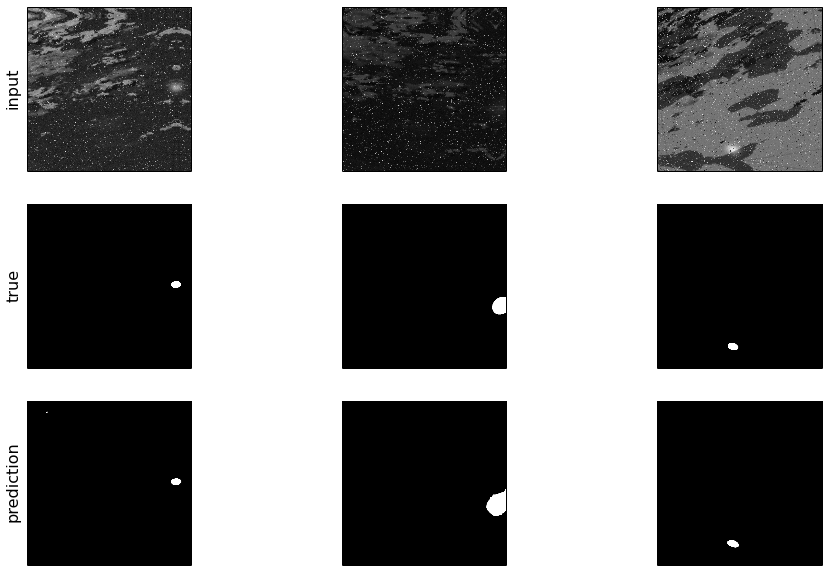

In [41]:
x_batch, y_batch = batch_generator(3).next()

y_pred = model.predict(x_batch)

f, axes = plt.subplots(3, 3, figsize=(16, 10))

axes[0, 0].set_ylabel('input', fontsize=16)
for i in range(3):
    ax = axes[0, i]
    ax.imshow(x_batch[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

axes[1, 0].set_ylabel('true', fontsize=16)
for i in range(3):
    ax = axes[1, i]
    ax.imshow(y_batch[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

axes[2, 0].set_ylabel('prediction', fontsize=16)
for i in range(3):
    ax = axes[2, i]
    ax.imshow(y_pred[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

In [22]:
!nvidia-smi

Sun Feb 18 18:40:11 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.74                 Driver Version: 375.74                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40c          On   | 0000:03:00.0     Off |                    0 |
| 23%   27C    P8    21W / 235W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          On   | 0000:04:00.0     Off |                    0 |
| 23%   43C    P0    63W / 235W |  11286MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  Q